In [1]:
!pip install torch torchdata
!pip install transformers datasets
!pip install -q -U bitsandbytes
!pip install -U accelerate
!pip install evaluate rouge_score
!pip install -qqq trl
!pip install loralib peft

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer,DataCollatorForSeq2Seq
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig
from datasets import load_dataset, DatasetDict, load_metric
import accelerate

import evaluate
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
seperator_print_short = '-'.join('' for x in range(100))
seperator_print_long = '-'.join('' for x in range(140))

def print_input_outputs(i, index, input, label, model_output):
    print(seperator_print_long)

    print(f"Sample {i+1}: Index = {index}")
    print(seperator_print_short)

    print(f"INPUT:")
    print(input)
    print(seperator_print_short)

    print("DATASET ORIGINAL LABEL:")
    print(label)
    print(seperator_print_short)

    if model_output != "":
        print("OUTPUT OF THE MODEL")
        print(model_output)
        print(seperator_print_short)

    print(seperator_print_long)



In [5]:
dataset_src = "/content/drive/MyDrive/arxiv-metadata-oai-snapshot.json"
dataset_origin = load_dataset('json',
                       data_files=dataset_src
                       )
dataset_origin

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2538935
    })
})

In [6]:
dset_train_test = (load_dataset('json',
                        data_files=dataset_src,
                        split='train'
                        )
          .train_test_split(train_size=0.7)
          )

dset_train_test

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 1777254
    })
    test: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 761681
    })
})

In [7]:
dset_test_val = dset_train_test["test"].train_test_split(train_size=0.75)

dset_test_val

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 571260
    })
    test: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 190421
    })
})

In [8]:
dataset = DatasetDict({
                      'train': dset_train_test['train'],
                      'validation': dset_test_val['train'],
                      'test': dset_test_val['test']}
                      )

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 1777254
    })
    validation: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 571260
    })
    test: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 190421
    })
})

In [9]:
dataset['train'] = dataset['train'].shuffle().select([i for i in range(6000)])
dataset['validation'] = dataset['validation'].shuffle().select([i for i in range(1000)])
dataset['test'] = dataset['test'].shuffle().select([i for i in range(250)])
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 250
    })
})

In [10]:
INPUT_COL_NAME = "abstract"
OUTPUT_COL_NAME = "title"

In [11]:
 from transformers import BitsAndBytesConfig

 BNB_NF4_CONFIG = BitsAndBytesConfig(
     load_in_4bit=True,
     bnb_4bit_use_double_quant=True,
     bnb_4bit_quant_type="nf4",
     bnb_4bit_compute_dtype=torch.bfloat16
 )

In [12]:
model_id='facebook/bart-base'

model = AutoModelForSeq2SeqLM.from_pretrained(model_id,
                                              quantization_config = BNB_NF4_CONFIG,
                                              device_map = "auto"
                                              )

tokenizer = AutoTokenizer.from_pretrained(model_id,
                                          use_fast=True,
                                          )


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [13]:
LORA_R = 8
LORA_ALPHA = 64
LORA_DROPOUT = 0.01

lora_config=LoraConfig(
    r = LORA_R,
    lora_alpha = LORA_ALPHA,
    target_modules = ["q_proj","v_proj"],
    # target_modules=["q", "v"],
    lora_dropout = LORA_DROPOUT,
    bias = "lora_only",
    task_type = TaskType.SEQ_2_SEQ_LM
)



peft_model=get_peft_model(model,lora_config)



In [14]:
def tokenize_function(example):
    START_prompt = 'Generate a relevant title related to the given abstracte:'
    END_prompt = '\n\nGenerated Title: '

    prompt = [START_prompt + abstract + END_prompt for abstract in example[INPUT_COL_NAME]]
    example['input_ids'] = tokenizer(prompt,
                                    truncation=True,
                                    padding=True,
                                    return_tensors="pt").input_ids

    example['labels'] = tokenizer(example["title"],
                                  truncation=True,
                                  padding=True,
                                  return_tensors="pt").input_ids

    return example


tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'])

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [15]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 250
    })
})


In [16]:
output_model_name = "bart"
output_config_option = "peftqlora"
output_task = "title-generation"


OUTPUT_DIR = f'./{output_model_name}-{output_config_option}-{output_task}'

In [17]:
peft_training_args = TrainingArguments(
    output_dir = OUTPUT_DIR,
    num_train_epochs = 4,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 2,
    learning_rate = 2e-4,
    optim = "paged_adamw_32bit" ,
    do_train = True,
    do_eval = True,
    evaluation_strategy = "epoch",
    logging_steps = 4,
    metric_for_best_model = 'eval_loss'
)



model.config.use_cache = False

peft_trainer = Trainer(
    model = peft_model,
    args = peft_training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets['validation'],
    data_collator=DataCollatorForSeq2Seq(tokenizer),
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
peft_trainer.train()

Epoch,Training Loss,Validation Loss
1,4.848600,4.171875
2,4.786600,4.117188
3,4.718300,4.101562
4,4.752000,4.089844


TrainOutput(global_step=3000, training_loss=4.922233723958334, metrics={'train_runtime': 2198.5195, 'train_samples_per_second': 10.916, 'train_steps_per_second': 1.365, 'total_flos': 1.003652417101824e+16, 'train_loss': 4.922233723958334, 'epoch': 4.0})

In [19]:
PATH_peft_model="./bart-lora-title-generator"

peft_trainer.model.save_pretrained(PATH_peft_model)
tokenizer.save_pretrained(PATH_peft_model)

('./bart-lora-title-generator/tokenizer_config.json',
 './bart-lora-title-generator/special_tokens_map.json',
 './bart-lora-title-generator/vocab.json',
 './bart-lora-title-generator/merges.txt',
 './bart-lora-title-generator/added_tokens.json',
 './bart-lora-title-generator/tokenizer.json')

In [20]:
peft_model = PeftModel.from_pretrained(model,
                                       PATH_peft_model,
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

In [21]:
TEST_INDEX = 21

abstract = dataset['test'][TEST_INDEX][INPUT_COL_NAME]
title = dataset['test'][TEST_INDEX][OUTPUT_COL_NAME]

prompt = f"""
Generate a title related to the given abstract:
{abstract}

Generated Title:
"""
inputs = tokenizer(prompt, return_tensors='pt')

output_peft = tokenizer.decode(
    peft_model.generate(
        input_ids = inputs['input_ids'].cuda(),
        generation_config = GenerationConfig(max_new_tokens=70,
                                             temperatue=1,
                                             do_sample=True),
    )[0],
    skip_special_tokens = True
)




print(prompt)
print(seperator_print_short)

print('Label:')
print(title)
print(seperator_print_short)

print('PEFT Summary:')
print(output_peft)
print(seperator_print_short)



Generate a title related to the given abstract:
  Electrocardiogram (ECG) is an authoritative source to diagnose and counter
critical cardiovascular syndromes such as arrhythmia and myocardial infarction
(MI). Current machine learning techniques either depend on manually extracted
features or large and complex deep learning networks which merely utilize the
1D ECG signal directly. Since intelligent multimodal fusion can perform at the
stateof-the-art level with an efficient deep network, therefore, in this paper,
we propose two computationally efficient multimodal fusion frameworks for ECG
heart beat classification called Multimodal Image Fusion (MIF) and Multimodal
Feature Fusion (MFF). At the input of these frameworks, we convert the raw ECG
data into three different images using Gramian Angular Field (GAF), Recurrence
Plot (RP) and Markov Transition Field (MTF). In MIF, we first perform image
fusion by combining three imaging modalities to create a single image modality
which serve

In [22]:
metric = evaluate.load("rouge")

def get_decoded_pred_samples(sample, max_target_length=40):

    outputs = peft_model.generate(input_ids=sample["input_ids"].unsqueeze(0).cuda(),
                             do_sample=True,

                             max_new_tokens=max_target_length)


    prediction = tokenizer.decode(outputs[0].detach().cpu().numpy(),
                                  skip_special_tokens=True)


    labels = np.where(sample['labels'] != -100,
                      sample['labels'],
                      tokenizer.pad_token_id)

    labels = tokenizer.decode(labels, skip_special_tokens=True)
    return prediction, labels


In [23]:
test_dataset = tokenized_datasets['test'].with_format("torch")

df_list_elements = []

predictions, references = [] , []
for sample in tqdm(test_dataset):
    pred, y = get_decoded_pred_samples(sample)
    predictions.append(pred)
    references.append(y)
    df_list_elements.append([sample, y, pred])

  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1364: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
100%|██████████| 250/250 [03:10<00:00,  1.31it/s]


In [24]:
for pred in predictions[:5]:
  print(pred)

The determination of the boundary parameter and the potential by the scattering matrix
Sparse Bayesian Learning: The Bessel K model
Parabolic systems with nonlinear dynamic boundary conditions
Topological string realization of SU(N) Chern-Simons theory on S^3
Goal-oriented adaptive finite element algorithm


In [25]:
rogue = metric.compute(predictions=predictions,
                       references=references,
                       use_stemmer=True)

print(f"Rogue1: {rogue['rouge1']* 100:2f}%")
print(f"rouge2: {rogue['rouge2']* 100:2f}%")
print(f"rougeL: {rogue['rougeL']* 100:2f}%")
print(f"rougeLsum: {rogue['rougeLsum']* 100:2f}%")

Rogue1: 39.519663%
rouge2: 21.218416%
rougeL: 35.215313%
rougeLsum: 35.769714%


In [26]:
df_model_results = pd.DataFrame(df_list_elements,
                                columns=["sample", "label", "prediction"])

df_model_results = df_model_results.drop('sample', axis=1)

df_model_results.to_csv('results.csv')
df_model_results

,label,prediction
0,"Inverse problems for selfadjoint Schr\""odinger...",The determination of the boundary parameter an...
1,Sparse Estimation using Bayesian Hierarchical ...,Sparse Bayesian Learning: The Bessel K model
2,Sup-norm estimates for parabolic systems with ...,Parabolic systems with nonlinear dynamic bound...
3,"Large N Duality, Mirror Symmetry, and a Q-defo...",Topological string realization of SU(N) Chern-...
4,Instance-optimal goal-oriented adaptivity,Goal-oriented adaptive finite element algorithm
...,...,...
245,Can we use next-generation gravitational wave ...,Measurement of Shapiro delay with next-generat...
246,Evolution equation for soft physics at high en...,Geometrical scaling in $pp(\bar{p}p)$ collisio...
247,Bessel Functions and Kloosterman Integrals on ...,Local integrability of Bessel functions for GL...
248,Spin-Charge Decoupling and Orthofermi Quantum ...,Bethe ansatz wave function compatible with ort...


In [27]:
df_trainer_logs = pd.DataFrame(peft_trainer.state.log_history)

df_trainer_logs

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,12.4248,7.713330,1.997333e-04,0.005333,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11.3242,4.408481,1.994667e-04,0.010667,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.0176,4.692383,1.992000e-04,0.016000,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.4424,4.706596,1.989333e-04,0.021333,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.1250,4.579123,1.986667e-04,0.026667,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,4.7769,2.265010,5.333333e-07,3.989333,2992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
751,4.7524,2.479370,2.666667e-07,3.994667,2996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
752,4.7520,2.558847,0.000000e+00,4.000000,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,NaN,NaN,NaN,4.000000,3000,4.089844,35.6046,28.086,3.511,NaN,NaN,NaN,NaN,NaN


In [28]:
df_trainer_logs.to_csv('train_logs.csv')

In [29]:
df_trainer_logs = df_trainer_logs[["epoch","loss","eval_loss","learning_rate","step"]]
df_trainer_logs

,epoch,loss,eval_loss,learning_rate,step
0,0.005333,12.4248,NaN,1.997333e-04,4
1,0.010667,11.3242,NaN,1.994667e-04,8
2,0.016000,11.0176,NaN,1.992000e-04,12
3,0.021333,10.4424,NaN,1.989333e-04,16
4,0.026667,10.1250,NaN,1.986667e-04,20
...,...,...,...,...,...
750,3.989333,4.7769,NaN,5.333333e-07,2992
751,3.994667,4.7524,NaN,2.666667e-07,2996
752,4.000000,4.7520,NaN,0.000000e+00,3000
753,4.000000,NaN,4.089844,NaN,3000


Text(0, 0.5, 'Loss')

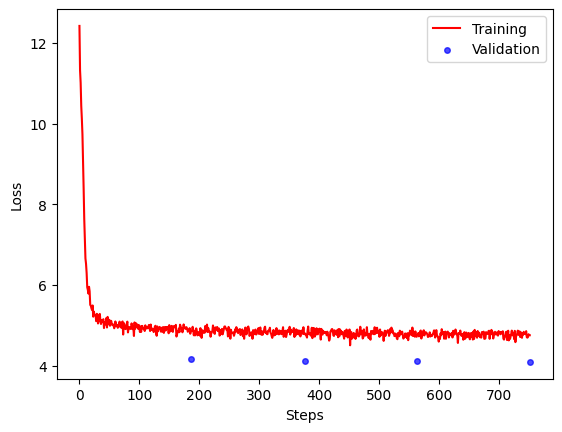

In [30]:
steps = df_trainer_logs.index
train_loss = df_trainer_logs.loss
eval_loss_list = df_trainer_logs.eval_loss

plt.plot(steps, train_loss, label="train_loss", color = "red")
plt.scatter(steps, eval_loss_list,
            c="blue", alpha=0.7, s=16)

plt.legend(["Training", "Validation"], loc ="upper right")
plt.xlabel("Steps")
plt.ylabel("Loss")